In [1]:
#Imports
from src.asset_class import EuropeanOption, OptionType, AsianOption, BarrierOption, BarrierType
from src.black_scholes import BlackScholesPricer
from src.monte_carlo import EuropeanOptionMCPricer, AsianOptionMCPricer,BarrierOptionMCPricer
from src.validation_tests import VanillaValidator,BarrierValidator,AsianValidator,ConvergenceAnalyzer

Parameters

In [2]:
# Setup Option & Market
S = 100
K = 100
barrier = 90
T = 1.0
r = 0.05
sigma = 0.2

# 1. Derivative Pricing Safety Checks

## Vanilla: Reference

In [3]:
# --- SCENARIO A :  Black-Scholes  ---
print("--- SCENARIO A : Pricing Using Black-Scholes Model ---\n")
bs_pricer = BlackScholesPricer(volatility=sigma, risk_free_rate=r)
bs_validator = VanillaValidator(bs_pricer)
check = bs_validator.run_tests(S, K, T)

--- SCENARIO A : Pricing Using Black-Scholes Model ---

Running validation on BlackScholesPricer...

[Put-Call Parity]: Checks if C - P = S - K * exp(-rT)
   P-C = 4.8771 vs S-K*exp(-rT) = 4.8771
   Err: 0.000000 -> PASS

[Martingale Test]: Checks if Price(Call | K=0) == S * exp(-qT)
   Price(Call | K=0) = 100.0000 vs. S*exp(-qT) = 100.0000
   Err: 0.000000 -> PASS


In [4]:
# --- SCENARIO B :  Monte Carlo ---
print("--- SCENARIO B : Pricing Using Monte Carlo Simulations ---\n")
mc_engine = EuropeanOptionMCPricer(volatility=sigma, risk_free_rate=r, n_simulations=1e7)
mc_validator = VanillaValidator(mc_engine)
check = mc_validator.run_tests(S, K, T)

--- SCENARIO B : Pricing Using Monte Carlo Simulations ---

Running validation on EuropeanOptionMCPricer...

[Put-Call Parity]: Checks if C - P = S - K * exp(-rT)
   P-C = 4.8779 vs S-K*exp(-rT) = 4.8771
   Err: 0.000838 -> PASS

[Martingale Test]: Checks if Price(Call | K=0) == S * exp(-qT)
   Price(Call | K=0) = 100.0023 vs. S*exp(-qT) = 100.0000
   Err: 0.002282 -> PASS


## Exotic Options with Monte-Carlo

In [5]:
# Asian Pricing Validation
ref_pricer = BlackScholesPricer(sigma, r)
asian_pricer = AsianOptionMCPricer(sigma, r, n_simulations=1e5)
print("--- ASIAN PRICING VALIDATION ---")
a_val = AsianValidator(asian_pricer, ref_pricer)

# Test 1: Bound
a_val.check_bounds_vs_european(S, K, T)

# Test 2: No volatility -> Deterministic path
zero_vol_engine = AsianOptionMCPricer(volatility=0.0001, risk_free_rate=r, n_simulations=1e3)
a_val.check_deterministic_zero_vol(S, K, T, r, zero_vol_engine=zero_vol_engine)

--- ASIAN PRICING VALIDATION ---

[Asian Bounds]: Testing Asian <= European
   European Ref: 10.4506
   Asian Price:  5.7895
   Diff (Eur-As): 4.6611 -> PASS

[Asian Zero-Vol]: Testing Deterministic Path
   Theoretical: 2.4182
   Engine Price: 2.4279
   Error: 0.009671 -> PASS


--- BARRIERE PRICING VALIDATION ---

[Barrier Parity]: Testing In + Out = European (H=90)
   In (10.43) + Out (0.00) = 10.43
   European Reference = 10.45
   Diff: 0.0205 (Tol: 0.1045) -> PASS

[Barrier Plot]: Generating Convergence Plot...
   Computing 20 points...


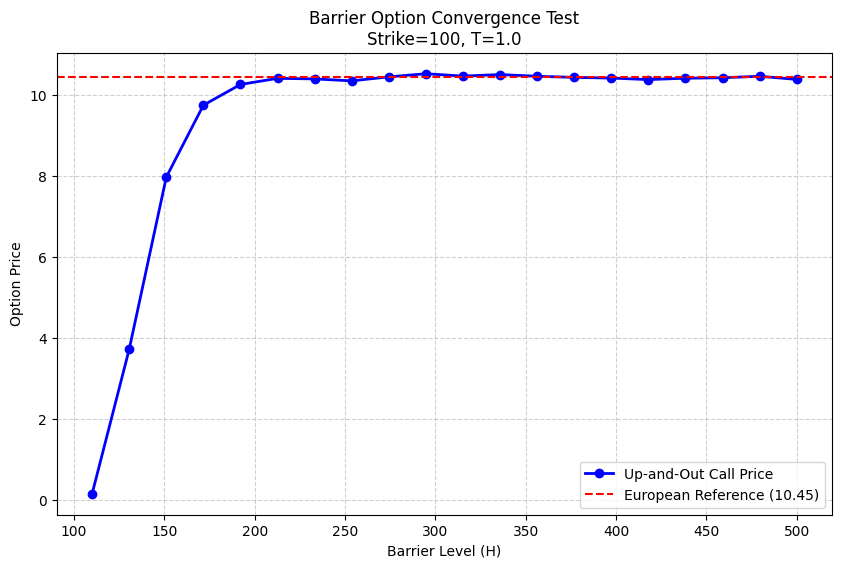

In [6]:
# Barrier Option Pricing Validation
barrier_pricer = BarrierOptionMCPricer(sigma, r, n_simulations=1e5)
print("--- BARRIERE PRICING VALIDATION ---")
b_val = BarrierValidator(barrier_pricer, ref_pricer)
b_val.run_tests(S,K,T,barrier)

# 2. Convergence Analysis


Running Convergence Test on EuropeanOptionMCPricer...
Simulations     | Price      | Std Error  | Ratio     
-------------------------------------------------------
1000.0          | 10.0632     | 0.441851   | N/A
10000.0         | 10.1724     | 0.146243   | 3.02
100000.0        | 10.4235     | 0.046381   | 3.15
1000000.0       | 10.4510     | 0.014728   | 3.15
10000000.0      | 10.4516     | 0.004656   | 3.16
100000000.0     | 10.4502     | 0.001472   | 3.16


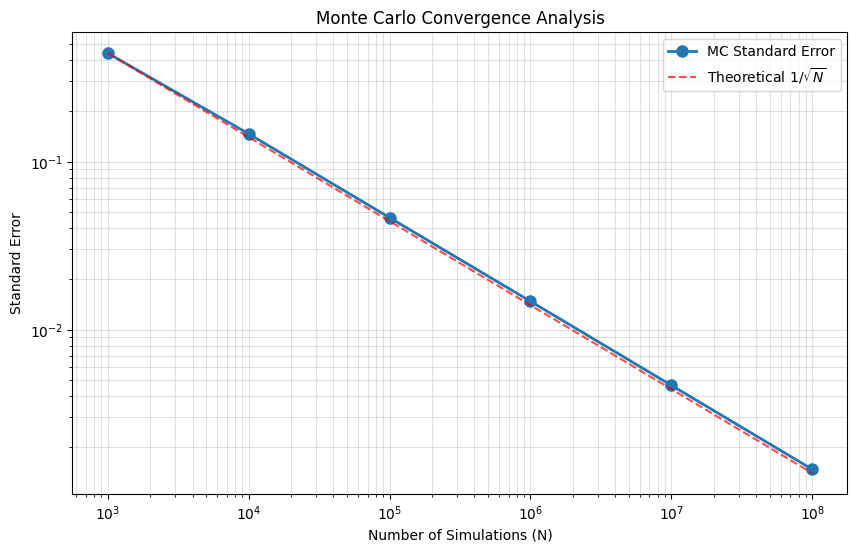

In [ ]:
# For an european call 
call = EuropeanOption(K, T, OptionType.CALL)
EO_analyzer = ConvergenceAnalyzer(EuropeanOptionMCPricer, volatility=sigma, risk_free_rate=r)
EO_analyzer.run_convergence_test(call, spot=S, simulation_steps=[1e3, 1e4, 1e5, 1e6, 1e7, 1e8])


Running Convergence Test on AsianOptionMCPricer...
Simulations     | Price      | Std Error  | Ratio     
-------------------------------------------------------
1000.0          | 5.4173     | 0.246233   | N/A
10000.0         | 5.7134     | 0.079873   | 3.08
100000.0        | 5.7741     | 0.025228   | 3.17
1000000.0       | 5.7836     | 0.008009   | 3.15


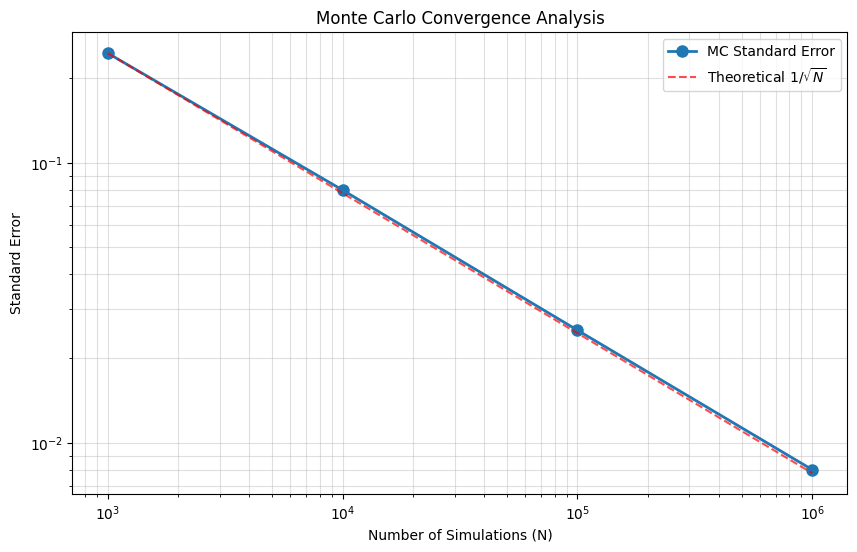

In [8]:
# For a asian call 
asian_call = AsianOption(K, T, OptionType.CALL)
EO_analyzer = ConvergenceAnalyzer(AsianOptionMCPricer, volatility=sigma, risk_free_rate=r)
EO_analyzer.run_convergence_test(asian_call, spot=S, simulation_steps=[1e3, 1e4, 1e5, 1e6])


Running Convergence Test on EuropeanOptionMCPricer...
Simulations     | Price      | Std Error  | Ratio     
-------------------------------------------------------
1000.0          | 10.3626     | 0.473039   | N/A
10000.0         | 10.5085     | 0.146847   | 3.22
100000.0        | 10.4639     | 0.046645   | 3.15
1000000.0       | 10.4378     | 0.014718   | 3.17


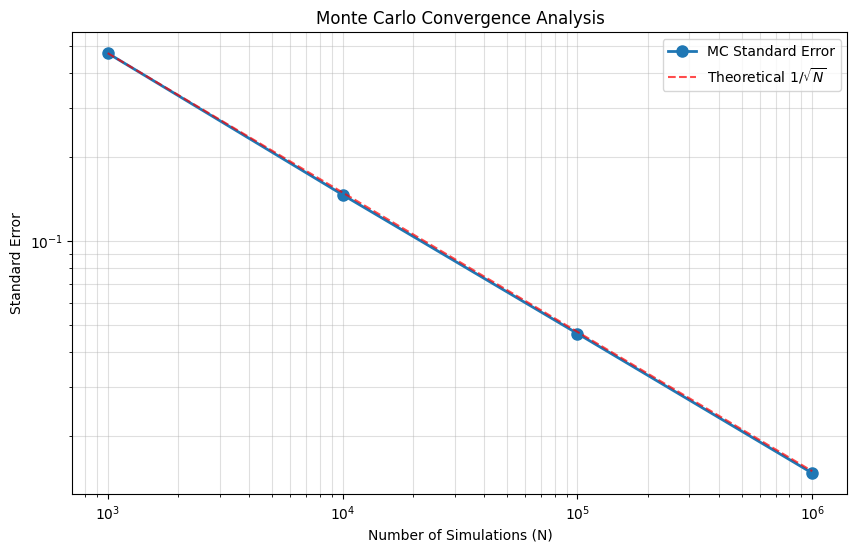

In [9]:
# For a barrier Down & Out call 
barrier_call = BarrierOption(K, T, OptionType.CALL,barrier=barrier,barrier_type=BarrierType.DOWN_AND_OUT)
EO_analyzer = ConvergenceAnalyzer(EuropeanOptionMCPricer, volatility=sigma, risk_free_rate=r)
EO_analyzer.run_convergence_test(call, spot=S, simulation_steps=[1e3, 1e4, 1e5, 1e6])